# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
impt_data = pd.read_csv("CLC_train.csv")

In [3]:
labels_pd = impt_data.pop("CO_level")
data_pd = impt_data.drop(["Date", "Time", "CO_GT", "NMHC_GT"], axis = 1)

In [4]:
data = data_pd.to_numpy()
labels = labels_pd.to_numpy()
data.shape

(7485, 11)

# Cleaning the data

In [5]:
remove_rows = data_pd[data_pd['AH'] == -200].index.to_numpy()

In [6]:
data = np.delete(data, tuple(remove_rows), axis = 0)
labels = np.delete(labels, tuple(remove_rows), axis = 0)

In [24]:
labels.shape

(7162,)

# Train Test Split

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0, test_size = 0.2)

In [9]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.transform(np.expand_dims(Y_val, 1)).toarray()

In [10]:
X_train, Y_OH_train, X_val, Y_OH_val = map(torch.tensor, (X_train, Y_OH_train, X_val, Y_OH_val))

In [11]:
X_train, X_val = X_train.float(), X_val.float()

In [12]:
data_pd

,PT08_S1_CO,C6H6_GT,PT08_S2_NMHC,Nox_GT,PT08_S3_Nox,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,2008,50.6,1980,1389,325,220,2562,2342,12.4,74.7,1.0741
1,1918,49.4,1958,1358,335,190,2477,2237,11.5,76.2,1.0324
2,1802,47.7,1924,748,356,192,2235,2452,13.7,52.8,0.8244
3,1982,49.5,1959,1369,322,227,2536,2386,13.2,72.6,1.0936
4,1956,45.2,1877,1389,347,255,2338,2465,15.5,62.8,1.0979
...,...,...,...,...,...,...,...,...,...,...,...
7480,864,2.7,633,-200,1097,-200,1259,523,16.4,70.3,1.3031
7481,929,3.8,698,-200,991,-200,1307,610,15.4,78.1,1.3557
7482,912,3.6,690,-200,984,-200,1309,574,15.8,75.5,1.3436
7483,817,2.2,602,-200,1120,-200,1227,470,16.0,69.5,1.2549


# Cuda Support

In [13]:
device = torch.device("cuda")

X_train = X_train.to(device)
X_val = X_val.to(device)
Y_OH_train = Y_OH_train.to(device)
Y_OH_val = Y_OH_val.to(device)

# FF Network

In [279]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(11, 2),
            nn.LeakyReLU(),
            nn.Linear(2, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 5),
#             nn.Sigmoid(),
            nn.Softmax()
#             nn.Linear(11, 22),
#             nn.ReLU(),
#             nn.Linear(22,50),
#             nn.ReLU(),
#             nn.Linear(50, 5),
#             nn.Softmax()
        )
           
    def forward(self, X):
        return(self.net(X))

In [280]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [281]:
lr = 0.02
epochs = 2000
ff_n = FF_Network()
ff_n = ff_n.to(device)
# ff_n.apply(init_weights)
loss_fn = F.cross_entropy
optm = optim.Adam(ff_n.parameters(), lr = lr)
# optm = optim.SGD(ff_n.parameters(), lr = lr, momentum = 0.9)
# optm = optim.SGD(ff_n.parameters(), lr = lr)

In [282]:
def accuracy(Y_hat, Y):
    return(accuracy_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1)))

In [283]:
def train(X, Y, model, loss_fn, optm, lr, epochs):
    loss_b = []
    acc_b = []
    Y_temp = Y.to('cpu')
    Y = np.argmax(Y_temp, 1)
    Y = Y.to(device)
    for i in tqdm_notebook(range(epochs)):
        Y_hat = model.forward(X)
        loss = loss_fn(Y_hat, Y)
        acc = accuracy(Y_hat, Y_temp)
        loss_b.append(loss.item())
        acc_b.append(acc)
        loss.backward()
        optm.step()
        optm.zero_grad()
    return(loss_b, acc_b, acc)

In [284]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_OH_train, ff_n, loss_fn, optm, lr = 0.05, epochs = 2500)

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Wall time: 21.7 s


Text(0, 0.5, 'acc')

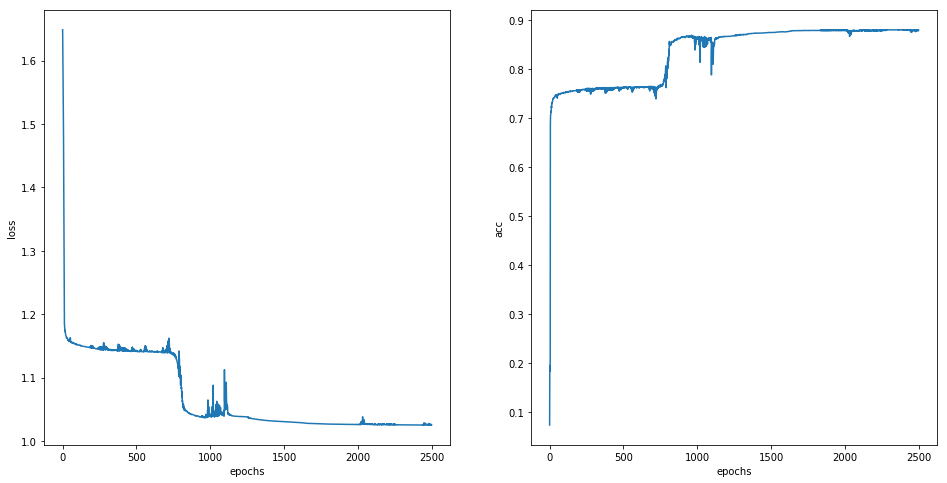

In [285]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')

In [286]:
print("Train set accuracy: ", acc_score, "\nValidation set accuracy: ", accuracy(ff_n.forward(X_val), Y_OH_val))

Train set accuracy:  0.8804328853203002 
Validation set accuracy:  0.8827634333565946


In [287]:
acc_b

[0.07366032466399022,
 0.18345260953045905,
 0.19514749519986035,
 0.18327805899807995,
 0.2064932798045034,
 0.6838889858614069,
 0.7036131960202479,
 0.7076278582649677,
 0.7085006109268633,
 0.7144353290277535,
 0.7125152731715831,
 0.7167044859486822,
 0.7249083609705009,
 0.7214173503229185,
 0.7280502705533252,
 0.7308430790713911,
 0.7297957758771164,
 0.7331122359923198,
 0.733461337057078,
 0.7338104381218362,
 0.7350322918484902,
 0.737650549834177,
 0.7381742014313144,
 0.7397451562227265,
 0.7397451562227265,
 0.7406179088846221,
 0.7418397626112759,
 0.740443358352243,
 0.7420143131436551,
 0.7421888636760342,
 0.7423634142084133,
 0.7425379647407925,
 0.7428870658055508,
 0.7428870658055508,
 0.7437598184674463,
 0.744807121661721,
 0.7451562227264793,
 0.746028975388375,
 0.7446325711293419,
 0.7449816721941002,
 0.7458544248559958,
 0.7455053237912376,
 0.744807121661721,
 0.7482981323093035,
 0.746028975388375,
 0.7465526269855123,
 0.746028975388375,
 0.74672717751789

In [288]:
loss_b

[1.648962140083313,
 1.6130845546722412,
 1.584969162940979,
 1.5678776502609253,
 1.54141104221344,
 1.5185258388519287,
 1.4785184860229492,
 1.425799012184143,
 1.3625024557113647,
 1.2903863191604614,
 1.2364041805267334,
 1.2040808200836182,
 1.1840944290161133,
 1.1823877096176147,
 1.175609827041626,
 1.1737568378448486,
 1.1747288703918457,
 1.1708556413650513,
 1.170433759689331,
 1.170229434967041,
 1.169133186340332,
 1.1667355298995972,
 1.1663013696670532,
 1.1650340557098389,
 1.1646220684051514,
 1.1638420820236206,
 1.162654161453247,
 1.1635615825653076,
 1.1624345779418945,
 1.1620697975158691,
 1.162063479423523,
 1.1618645191192627,
 1.1614950895309448,
 1.1612298488616943,
 1.1604803800582886,
 1.160001516342163,
 1.1594234704971313,
 1.1584283113479614,
 1.1598448753356934,
 1.1595696210861206,
 1.1590251922607422,
 1.1586658954620361,
 1.1592578887939453,
 1.156728982925415,
 1.1586873531341553,
 1.1577541828155518,
 1.1581504344940186,
 1.1575292348861694,
 1.15

In [296]:
ff_n.forward(X_train[2355])

C:\Users\Sriram Pingali\Anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([2.4667e-15, 1.0000e+00, 5.5203e-20, 1.5417e-17, 1.3342e-18],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [297]:
Y_OH_train[2355]

tensor([0., 1., 0., 0., 0.], device='cuda:0', dtype=torch.float64)